# Usage example of pyrcca

In this example, Pyrcca is used to find linear relationships between two artificially constructed interdependent datasets. Both datasets have 1000 samples. One dataset has 4 dimensions, and the other has 5 dimensions. These datasets depend on two latent variables. Each dimension in both datasets is constructed as a sum of an independent component (25%) and one of the two latent variables (75%). Each dataset is split in two halves: a training set and a test set. 

Pyrcca is used to find a CCA mapping between the training sets. The quality of the mapping is assessed using cross-dataset prediction with test data. Each test set is projected onto the canonical space, and the other test set is predicted using the CCA mapping. The prediction accuracy is quantified by correlating predicted test data with actual test data.

The analysis is first run with predefined hyperparameters. Then, grid search with cross-validation is used to find optimal hyperparameters.

This example demonstrates that Pyrcca can be used to recover linear relationships for two artificially generated datasets. It is designed to be easily adaptable.

## Pyrcca with predefined hyperparameters

### Initialization

In [1]:
# Imports
import numpy as np
import rcca

# Initialize number of samples
nSamples = 1000

# Define two latent variables (number of samples x 1)
latvar1 = np.random.randn(nSamples,)
latvar2 = np.random.randn(nSamples,)

# Define independent components for each dataset (number of observations x dataset dimensions)
indep1 = np.random.randn(nSamples, 4)
indep2 = np.random.randn(nSamples, 5)

# Create two datasets, with each dimension composed as a sum of 75% one of the latent variables and 25% independent component
data1 = 0.25*indep1 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2)).T
data2 = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T

# Split each dataset into two halves: training set and test set
train1 = data1[:nSamples/2]
train2 = data2[:nSamples/2]
test1 = data1[nSamples/2:]
test2 = data2[nSamples/2:]

### Analysis
There are many more samples than dimensions in the dataset, therefore kernelization and regularization are unnecessary.

There are two latent variables, and CCA is expected to find two underlying canonical components that capture the relationships between the datasets. However, it is possible to compute up to four canonical components, so the analysis is first used to find four components. This is done in order to test whether the first two components capture the relationships present in the data.

In [2]:
# Create a cca object as an instantiation of the CCA object class. 
nComponents = 4
cca = rcca.CCA(kernelcca = False, reg = 0., numCC = nComponents)

# Use the train() method to find a CCA mapping between the two training sets.
cca.train([train1, train2])

# Use the validate() method to test how well the CCA mapping generalizes to the test data.
# For each dimension in the test data, correlations between predicted and actual data are computed.
testcorrs = cca.validate([test1, test2])

Training CCA, regularization = 0.0000, 4 components


### Results

In [3]:
# Imports
import matplotlib.pyplot as plt
from brewer2mpl import qualitative
%matplotlib inline

#### Canonical correlations

The canonical correlations are:

Component 1: 0.95

Component 2: 0.95

Component 3: 0.10

Component 4: 0.00




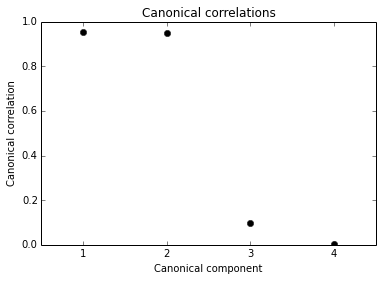

In [4]:
# Plot canonical correlations (cca.cancorrs)
plt.plot(np.arange(nComponents)+1, cca.cancorrs, 'ko')
plt.xlim(0.5, 0.5+nComponents)
plt.xticks(np.arange(nComponents)+1)
plt.xlabel('Canonical component')
plt.ylabel('Canonical correlation')
plt.title('Canonical correlations')
print '''The canonical correlations are:\n
Component 1: %.02f\n
Component 2: %.02f\n
Component 3: %.02f\n
Component 4: %.02f\n
''' % tuple(cca.cancorrs)

As expected, two canonical components capture correlational relationships between the datasets, and the first two canonical correlations are both 0.95. The third and the fourth canonical components do not capture meaningful relationships between the datasets. The third and the fourth canonical correlations are very low, 0.10 and 0.00.

#### Cross-dataset predictions

The prediction accuracy for the first dataset is:

Dimension 1: 0.92

Dimension 2: 0.91

Dimension 3: 0.91

Dimension 4: 0.91


The prediction accuracy for the second dataset is:

Dimension 1: 0.91

Dimension 2: 0.93

Dimension 3: 0.90

Dimension 4: 0.91

Dimension 5: 0.90




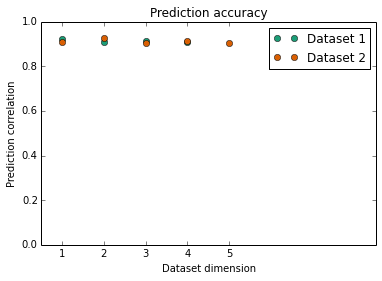

In [5]:
# Plot correlations between actual test data and predictions 
# obtained by projecting the other test dataset via the CCA mapping for each dimension.
nTicks = max(testcorrs[0].shape[0], testcorrs[1].shape[0])
bmap1 = qualitative.Dark2[3]
plt.plot(np.arange(testcorrs[0].shape[0])+1, testcorrs[0], 'o', color = bmap1.mpl_colors[0])
plt.plot(np.arange(testcorrs[1].shape[0])+1, testcorrs[1], 'o', color = bmap1.mpl_colors[1])
plt.xlim(0.5, 0.5 + nTicks + 3)
plt.ylim(0.0, 1.0)
plt.xticks(np.arange(nTicks)+1)
plt.xlabel('Dataset dimension')
plt.ylabel('Prediction correlation')
plt.title('Prediction accuracy')
plt.legend(['Dataset 1', 'Dataset 2'])
print '''The prediction accuracy for the first dataset is:\n
Dimension 1: %.02f\n
Dimension 2: %.02f\n
Dimension 3: %.02f\n
Dimension 4: %.02f\n
'''% tuple(testcorrs[0])
print '''The prediction accuracy for the second dataset is:\n
Dimension 1: %.02f\n
Dimension 2: %.02f\n
Dimension 3: %.02f\n
Dimension 4: %.02f\n
Dimension 5: %.02f\n
'''% tuple(testcorrs[1])

Both datasets are predicted with close to perfect accuracy, with correlations ranging from 0.90 to 0.93 for each dimension.

## Pyrcca with hyperparameter grid search using cross-validation

Instead of predefining hyperparameters, grid search with cross-validation can be used to find the optimal hyperparameters. Since there are two latent variables, two canonical components are expected to be optimal. Additionally, since the latent variables are not necessarily orthogonal, the optimal regularization coefficient should be greater than zero. The exact value of the optimal regularization coefficient will depend on the instantiation, since the data are randomly generated.
All possible numbers of components are tested: 1, 2, 3, 4. Four possible regularization coefficients are tested: 0, 1e2, 1e4, 1e6.

### Analysis

In [6]:
# Initialize a cca object as an instantiation of the CCACrossValidate class.
ccaCV = rcca.CCACrossValidate(kernelcca=False, numCCs = [1, 2, 3, 4], regs = [0., 1e2, 1e4, 1e6])

# Use the train() and validate() methods to run the analysis and perform cross-dataset prediction.
ccaCV.train([train1, train2])
testcorrsCV = ccaCV.validate([test1, test2])

Training CV CCA, regularization = 0.0000, 1 components, fold #1
Training CV CCA, regularization = 0.0000, 1 components, fold #2
Training CV CCA, regularization = 0.0000, 1 components, fold #3
Training CV CCA, regularization = 0.0000, 1 components, fold #4
Training CV CCA, regularization = 0.0000, 1 components, fold #5
Training CV CCA, regularization = 0.0000, 1 components, fold #6
Training CV CCA, regularization = 0.0000, 1 components, fold #7
Training CV CCA, regularization = 0.0000, 1 components, fold #8
Training CV CCA, regularization = 0.0000, 1 components, fold #9
Training CV CCA, regularization = 0.0000, 1 components, fold #10
Training CV CCA, regularization = 0.0000, 2 components, fold #1
Training CV CCA, regularization = 0.0000, 2 components, fold #2
Training CV CCA, regularization = 0.0000, 2 components, fold #3
Training CV CCA, regularization = 0.0000, 2 components, fold #4
Training CV CCA, regularization = 0.0000, 2 components, fold #5
Training CV CCA, regularization = 0.000

In [7]:
print 'Optimal number of components: %d\nOptimal regularization coefficient: %d' % (ccaCV.best_numCC, ccaCV.best_reg)

Optimal number of components: 2
Optimal regularization coefficient: 10000


As expected, the optimal number of components is two, corresponding to the number of latent variables. The optimal regularization coefficient is greater than zero: 1e4.

### Results

#### Canonical correlations

The canonical correlations are:

Component 1: 0.95

Component 2: 0.95




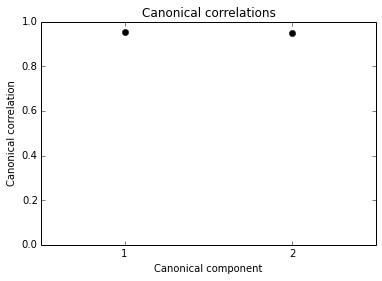

In [8]:
# Plot canonical correlations (cca.cancorrs)
plt.plot(np.arange(ccaCV.best_numCC)+1, ccaCV.cancorrs, 'ko')
plt.xlim(0.5, 0.5+ccaCV.best_numCC)
plt.xticks(np.arange(ccaCV.best_numCC)+1)
plt.ylim(0,1)
plt.xlabel('Canonical component')
plt.ylabel('Canonical correlation')
plt.title('Canonical correlations')
print '''The canonical correlations are:\n
Component 1: %.02f\n
Component 2: %.02f\n
''' % tuple(ccaCV.cancorrs)

The canonical correlations for both components are both 0.95.

#### Cross-dataset predictions

The prediction accuracy for the first dataset is:

Dimension 1: 0.94

Dimension 2: 0.93

Dimension 3: 0.93

Dimension 4: 0.93


The prediction accuracy for the second dataset is:

Dimension 1: 0.93

Dimension 2: 0.93

Dimension 3: 0.93

Dimension 4: 0.93

Dimension 5: 0.93




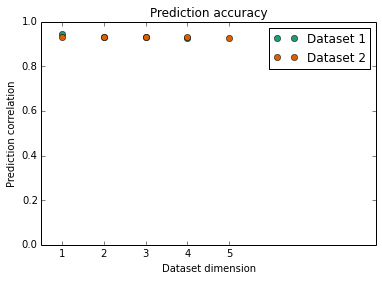

In [9]:
# Plot correlations between actual test data and predictions 
# obtained by projecting the other test dataset via the CCA mapping for each dimension.
nTicks = max(testcorrsCV[0].shape[0], testcorrsCV[1].shape[0])
bmap1 = qualitative.Dark2[3]
plt.plot(np.arange(testcorrsCV[0].shape[0])+1, testcorrsCV[0], 'o', color = bmap1.mpl_colors[0])
plt.plot(np.arange(testcorrsCV[1].shape[0])+1, testcorrsCV[1], 'o', color = bmap1.mpl_colors[1])
plt.xlim(0.5, 0.5 + nTicks + 3)
plt.ylim(0.0, 1.0)
plt.xticks(np.arange(nTicks)+1)
plt.xlabel('Dataset dimension')
plt.ylabel('Prediction correlation')
plt.title('Prediction accuracy')
plt.legend(['Dataset 1', 'Dataset 2'])
print '''The prediction accuracy for the first dataset is:\n
Dimension 1: %.02f\n
Dimension 2: %.02f\n
Dimension 3: %.02f\n
Dimension 4: %.02f\n
'''% tuple(testcorrsCV[0])
print '''The prediction accuracy for the second dataset is:\n
Dimension 1: %.02f\n
Dimension 2: %.02f\n
Dimension 3: %.02f\n
Dimension 4: %.02f\n
Dimension 5: %.02f\n
'''% tuple(testcorrsCV[1])

The cross-dataset predictions range between 0.93 and 0.94 for all dimensions for both datasets.

## Variation of the optimal hyperparameters over many iterations
The optimal regularization coefficient will vary with different instantiations of the data. It's possible that the optimal number of components would vary as well. Below, the data are randomly generated in the same manner for 1000 iterations. Then, the analysis is repeated to determine which optimal number of canonical components and optimal regularization coefficient persist over different instantiations of the data.

In [10]:
nIterations = 1000
all_numCC = np.zeros((nIterations,))
all_reg = np.zeros((nIterations,))

for ii in range(nIterations):
    # Initialize number of samples
    nSamples = 1000
    
    # Define two latent variables (number of samples x 1)
    latvar1 = np.random.randn(nSamples,)
    latvar2 = np.random.randn(nSamples,)
    
    # Define independent components for each dataset (number of samples x dataset dimensions)
    indep1 = np.random.randn(nSamples, 4)
    indep2 = np.random.randn(nSamples, 5)
    
    # Create two datasets, with each dimension composed as a sum of 75% one of the latent variables and 25% independent component
    data1 = 0.25*indep1 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2)).T
    data2 = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T
    
    # Split each dataset into two halves: training set and test set
    train1 = data1[:nSamples/2]
    train2 = data2[:nSamples/2]
    test1 = data1[nSamples/2:]
    test2 = data2[nSamples/2:]

    # Analysis
    # Initialize a cca object as an instantiation of the CCACrossValidate class.
    ccaCV = rcca.CCACrossValidate(kernelcca=False, numCCs = [1, 2, 3, 4], regs = [0., 1e2, 1e4, 1e6], verbose = False)

    # Use the train() and validate() methods to run the analysis and perform cross-dataset prediction.
    ccaCV.train([train1, train2])
    
    all_numCC[ii] = ccaCV.best_numCC
    all_reg[ii] = ccaCV.best_reg

In [11]:
print '''Number of times each number of components was chosen:\n
1 component: %d\n
2 components: %d\n
3 components: %d\n
4 components: %d\n
''' % tuple([(all_numCC == i).sum() for i in (1, 2, 3, 4)])

Number of times each number of components was chosen:

1 component: 14

2 components: 972

3 components: 14

4 components: 0




The optimal number of components is two for 97% of the iterations, corresponding to the number of latent variables. Pyrcca successfully captures the relationships in the data prescribed by the latent variables.

In [12]:
print '''Number of times each regularization coefficient was chosen:\n
Regularization coefficient = 0: %d\n
Regularization coefficient = 1e2: %d\n
Regularization coefficient = 1e4: %d\n
Regularization coefficient = 1e6: %d\n
''' % tuple([(all_reg == i).sum() for i in (0, 1e2, 1e4, 1e6)])

Number of times each regularization coefficient was chosen:

Regularization coefficient = 0: 86

Regularization coefficient = 1e2: 295

Regularization coefficient = 1e4: 296

Regularization coefficient = 1e6: 323




The optimal regularization coefficient is greater than zero for over 90% of the iterations. The other three regularization coefficients are optimal for approximately equal proportions of iterations. This result corresponds to the random variation in the data that are generated during each iteration of the analysis.